# Bayesian Methods for Heteroscedasticity

Sometimes your data is heteroscedastic and you don't want to have to do dumb things to deal with that. Bayesian methods to the rescue on both counts.

Heteroscedasticity is basically when the variance of your target variable is different for given values of your data. Or in a more mathy way, variance of y is conditional on x.

First let's make some fake data just so you know what we're dealing with.

In [1]:
import numpy as np
import pymc3 as pm
import scipy.stats as stats

import matplotlib.pyplot as graph
import seaborn as sns

from rosey.stats import r2_pymc3


graph.style.use('fivethirtyeight')

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
/home/stephen/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def plot_ppc(trace, model, n_draws=100):
    sub_trace = pm.trace_to_dataframe(trace[-1:-n_draws:-1])
    
    xs = np.linspace(x.min(), x.max(), 100)
    
    for _, posterior in sub_trace.iterrows():
        graph.plot(xs, posterior['m']*xs + posterior['b'], linewidth=1, alpha=0.05, color='#008fd5')
    graph.plot(x, y, 'o', color='#fc4f30')
    graph.show()

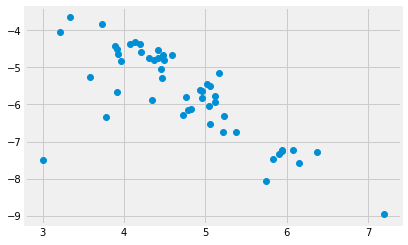

In [3]:
# Making up some heteroscedastic data
n = 50
m_true = -1.2
sd_given_x = 12

x = stats.norm(5, 1).rvs(size=n)
y = m_true * x + stats.norm(0, sd_given_x / (x**2)).rvs(size=len(x))

# Now add an outlier!
x = np.append(x, 3)
y = np.append(y, -7.5)

graph.plot(x, y, 'o')
graph.show()

# Making a Model

This is actually the easy part.

$$y = mx + b$$
$$y \sim \mathcal{N}(mx + b, \sigma)$$

And we will just say that $m$ and $b$ come from normal distributions and $\sigma$ is a half normal

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, m]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:05<00:00, 1840.17draws/s]
The acceptance probability does not match the target. It is 0.8963480514902855, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8825617301928556, but should be close to 0.8. Try to increase the number of tuning steps.


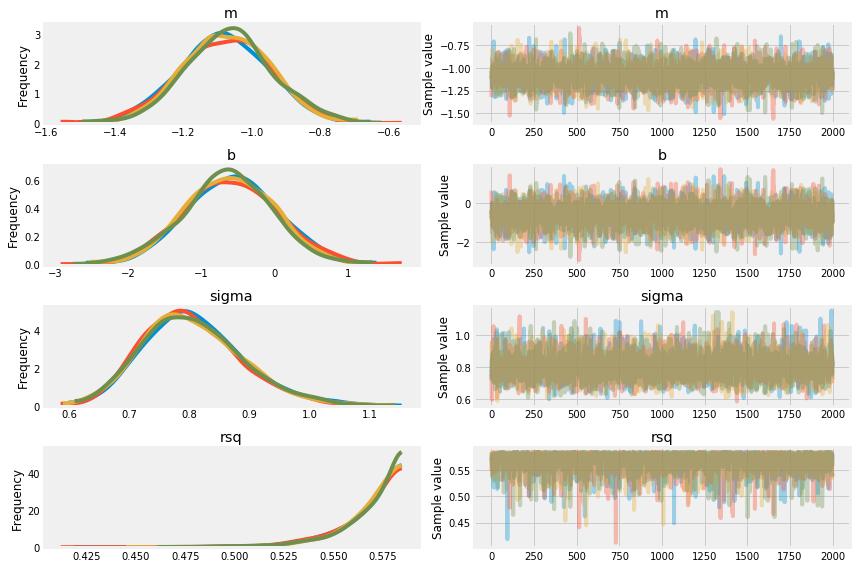

In [4]:
with pm.Model() as simple_model:
    # Priors
    m = pm.Normal('m', mu=0, sd=100**2)
    b = pm.Normal('b', mu=0, sd=100**2)
    sig = pm.HalfNormal('sigma', sd=100**2)
    
    # Likelihood    
    rsq = pm.Deterministic('rsq', r2_pymc3(y, m*x + b))
    
    obs = pm.Normal('y', mu=m*x + b, sd=sig, observed=y)
    
    trace_simple_model = pm.sample(2000)
    
    pm.traceplot(trace_simple_model)
    graph.show()

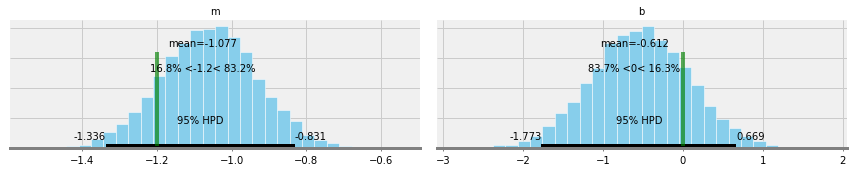

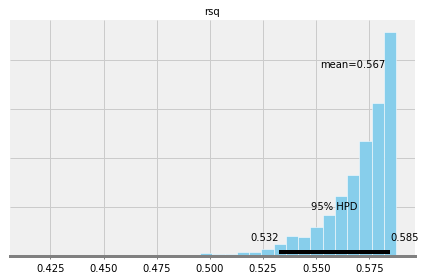

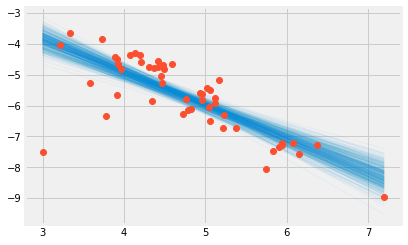

In [5]:
pm.plot_posterior(trace_simple_model, varnames=['m', 'b'], ref_val=[m_true, 0])
graph.show()

pm.plot_posterior(trace_simple_model, varnames=['rsq'])
graph.show()

plot_ppc(trace_simple_model, simple_model)

# Dealing with Heteroscedastic

1. First way is using a Cauchy distribution as the likelihood.
2. Second way making the variance conditional on the data.

## Method 1. Cauchy Likelihood Function

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, m]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:05<00:00, 1751.24draws/s]
The acceptance probability does not match the target. It is 0.881284089478335, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8930538518637965, but should be close to 0.8. Try to increase the number of tuning steps.


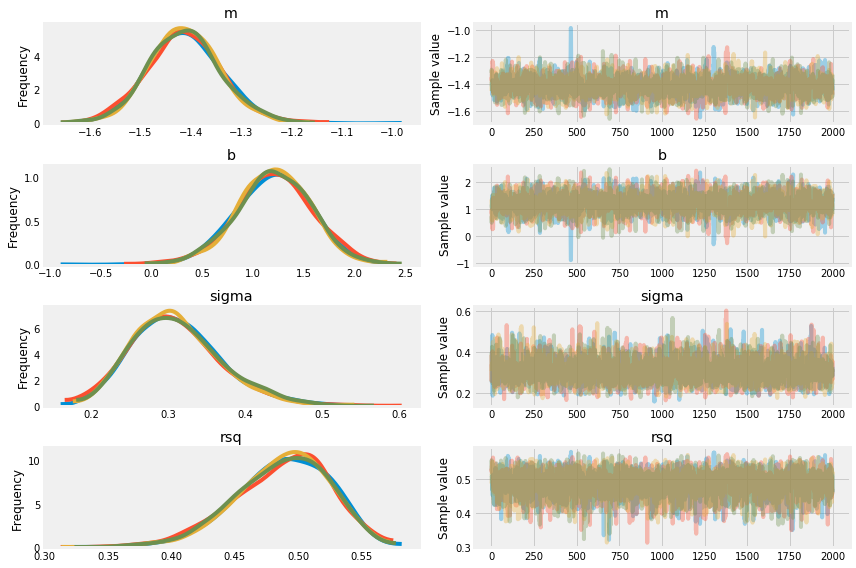

In [6]:
# Method 1. Cauchy Method
with pm.Model() as cauchy_model:
    # Priors
    m = pm.Normal('m', mu=0, sd=100**2)
    b = pm.Normal('b', mu=0, sd=100**2)
    sig = pm.HalfNormal('sigma', sd=100**2)
    
    # Likelihood    
    rsq = pm.Deterministic('rsq', r2_pymc3(y, m*x + b))
    
    obs = pm.Cauchy('y', alpha=m*x + b, beta=sig, observed=y)
    
    trace_cauchy_model = pm.sample(2000)
    
    pm.traceplot(trace_cauchy_model)
    graph.show()

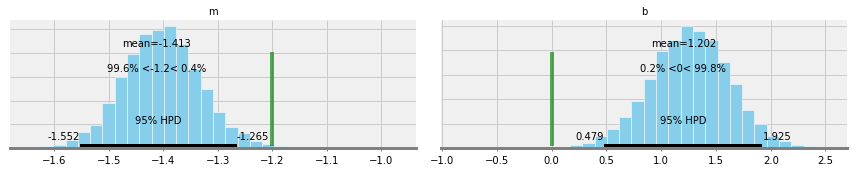

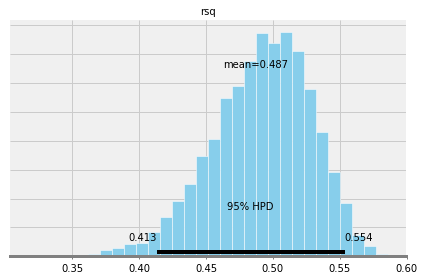

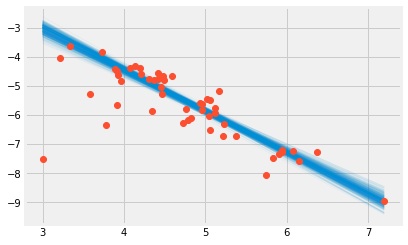

In [7]:
pm.plot_posterior(trace_cauchy_model, varnames=['m', 'b'], ref_val=[m_true, 0])
graph.show()

pm.plot_posterior(trace_cauchy_model, varnames=['rsq'])
graph.show()

plot_ppc(trace_cauchy_model, cauchy_model)

## Method 2. Modeling variance given the data

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_b, sigma_m, b, m]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:07<00:00, 1365.23draws/s]
The acceptance probability does not match the target. It is 0.8926661941308094, but should be close to 0.8. Try to increase the number of tuning steps.


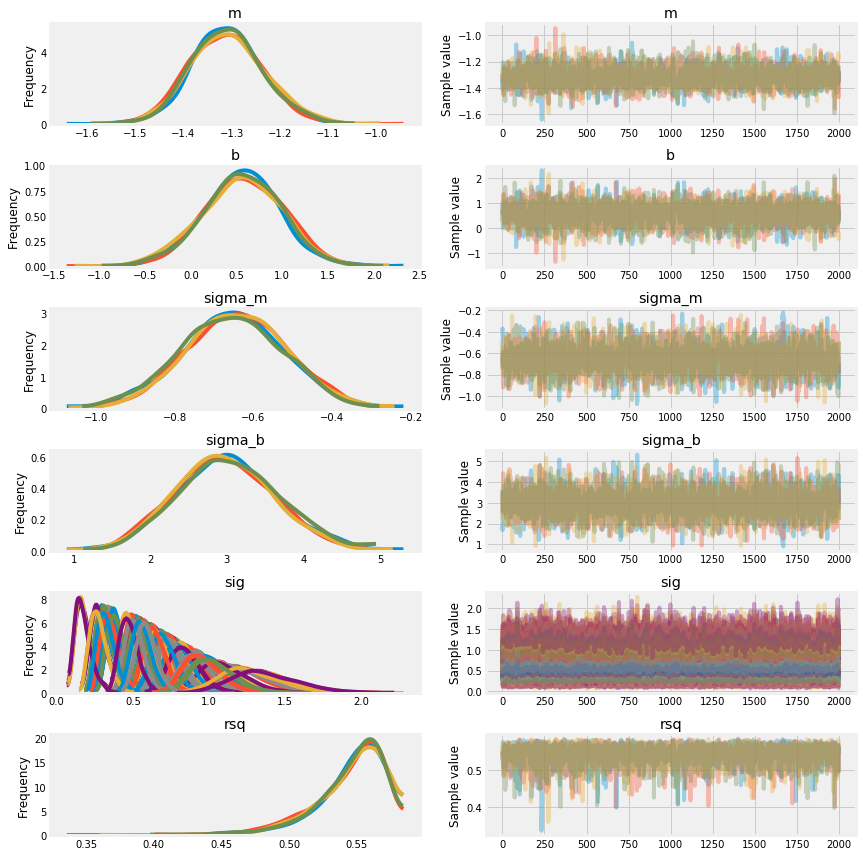

In [8]:
# Method 2. modeling 
with pm.Model() as fancy_model:
    n_samples = len(y)
    data, target = x, y
    
    # Priors
    m = pm.Normal('m', mu=0, sd=100**2)
    b = pm.Normal('b', mu=0, sd=100**2)
    
    sig_m = pm.Normal('sigma_m', mu=0, sd=100**2)
    sig_b = pm.Normal('sigma_b', mu=0, sd=100**2)
    sig_given_data = pm.Deterministic('sig', pm.math.log(1 + pm.math.exp(sig_m * data + sig_b)))
    
    # Likelihood    
    rsq = pm.Deterministic('rsq', r2_pymc3(y, m*x + b))
    
    obs = pm.Normal('y', mu=m*data + b, sd=sig_given_data, observed=target)
    
    trace_fancy_model = pm.sample(2000)
    
    pm.traceplot(trace_fancy_model)
    graph.show()

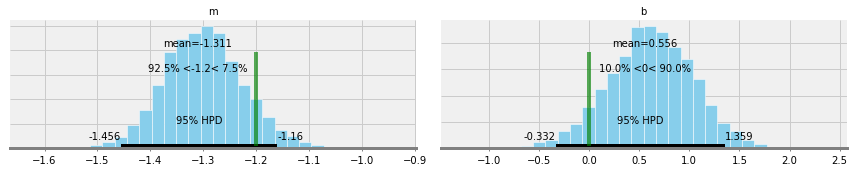

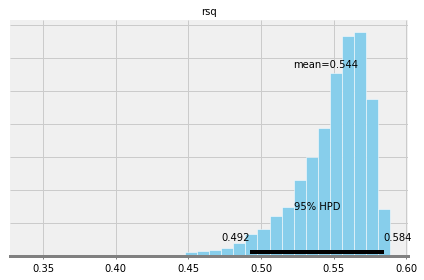

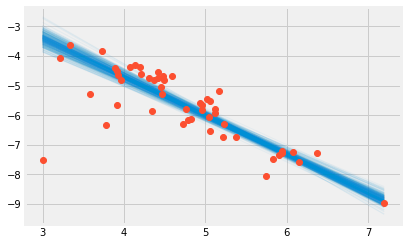

In [9]:
pm.plot_posterior(trace_fancy_model, varnames=['m', 'b'], ref_val=[m_true, 0])
graph.show()

pm.plot_posterior(trace_fancy_model, varnames=['rsq'])
graph.show()

plot_ppc(trace_fancy_model, fancy_model)

# Comparisons

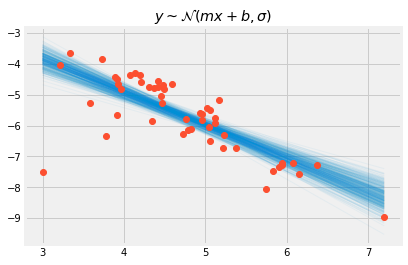

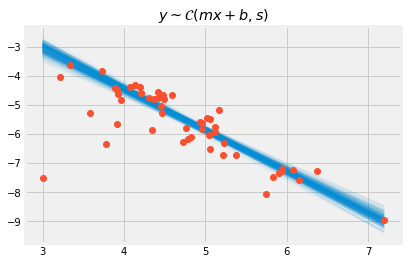

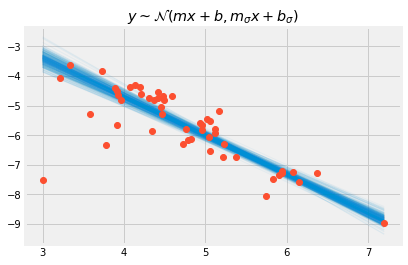

In [10]:
graph.title(r'$y \sim \mathcal{N}(mx+b, \sigma)$')
plot_ppc(trace_simple_model, simple_model)

graph.title(r'$y \sim \mathcal{C}(mx+b, s)$')
plot_ppc(trace_cauchy_model, cauchy_model)

graph.title(r'$y \sim \mathcal{N}(mx+b, m_\sigma x + b_\sigma)$')
plot_ppc(trace_fancy_model, fancy_model)

_Stephen Anthony Rose_